In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

def get_word2idx_idx2word(vocab):
    word2idx = {word: idx+1 for idx, word in enumerate(vocab)}
    word2idx[''] = 0

    idx2word = {idx+1: word for idx, word in enumerate(vocab)}
    idx2word[0] = ''
    return word2idx, idx2word

def char_to_num(texts, word2idx):
    return [word2idx[char] for char in texts if char in word2idx]

def num_to_char(nums, idx2word):
    return [idx2word.get(num, '') for num in nums]

In [4]:
class LipDataset(Dataset):
    def __init__(self, data_dir: str, label_dir: str, vocab: list, word2idx: dict, idx2word: dict, transform=transforms.ToTensor()) -> None:
        self.data_dir = data_dir
        self.label_dir = label_dir
        self.transform = transform
        self.data = os.listdir(data_dir)
        self.data.remove('sgib8n.mpg')
        self.label = os.listdir(label_dir)
        self.vocab = vocab
        self.word2idx = word2idx
        self.idx2word = idx2word

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
            data_path = os.path.join(self.data_dir, self.data[idx])
            label_file = self.data[idx].split(".")[0] + ".align"
            label_path = os.path.join(self.label_dir, label_file)

            assert os.path.exists(data_path), f"Data path {data_path} does not exist"
            assert os.path.exists(label_path), f"Label path {label_path} does not exist"

            assert (
                data_path.split("/")[-1].split(".")[0]
                == label_path.split("/")[-1].split(".")[0]
            ), "Data and label file names do not match"

            frames = self.load_video(data_path)
            if frames is None:
                print(idx)

            label = self.load_alignment(label_path)
            
#             print(idx, label_file)

            return frames, label
        except Exception as e:
            print(idx, e)
            
    def get_data_name(self, idx):
        return self.data[idx].split(".")[0]
    def get_data_idx(self, name):
        return self.data.index(name + ".mpg")
    

    def load_video(self, path: str) -> torch.Tensor:
        cap = cv2.VideoCapture(path)
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        frames = []
        for i in range(num_frames):
            ret, frame = cap.read()
            
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            frame = frame[
                190:236, 80:220, :
            ]  # TODO: Make it dynamic using dlib  # Take only the lip part of the frame
            
            if self.transform:
                frame = self.transform(frame)

            frames.append(frame)

        cap.release()
        
        frames = torch.stack(frames)
        
        std = torch.std(frames)
        mean = torch.mean(frames)
#         print(std, mean)
        frames = (frames - mean) / std # Normalize the frames (z-score normalization

        return frames # (T, H, W, C)
    
    
    def load_alignment(self, path: str) -> torch.Tensor:
        with open(path, "r") as f:
            lines = f.readlines() 
        tokens = []
        for line in lines:
            line = line.split()
            if line[2] != "sil":
                # tokens = [*tokens, ' ',line[2]]
                tokens.append(' ')
                tokens.extend(list(line[2]))  

        token_nums = char_to_num(tokens, self.word2idx)
        return torch.tensor(token_nums[1:], dtype=torch.long)

In [5]:
word2idx, idx2word = get_word2idx_idx2word(vocab)

data_transform = transforms.Compose(
    [
        # transforms.ToPILImage(),                     
        transforms.ToTensor(),       
        # transforms.Grayscale(num_output_channels=1),
    ]
)

data_dir = "/kaggle/input/lipnet-videos/s1"
label_dir = "/kaggle/input/lipnet-videos/alignments/s1"

dataset = LipDataset(data_dir, label_dir, transform=data_transform, vocab=vocab, word2idx=word2idx, idx2word=idx2word)

In [6]:
def collate_fn(batch):
    frames, labels = zip(*batch)

    # Pad the frames to the same length
    max_len = max([f.shape[0] for f in frames])
    frames = [torch.nn.functional.pad(input=f, pad=(0, 0, 0, 0, 0, 0, 0, max_len - f.shape[0]), mode='constant', value=0) for f in frames] 
    

    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)
    
    return torch.stack(frames), labels

In [7]:
frames, label = dataset[0]
print(frames.shape, label, label.shape)

torch.Size([75, 3, 46, 140]) tensor([ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39, 13, 39, 14,  9, 14,
         5, 39, 19, 15, 15, 14]) torch.Size([24])


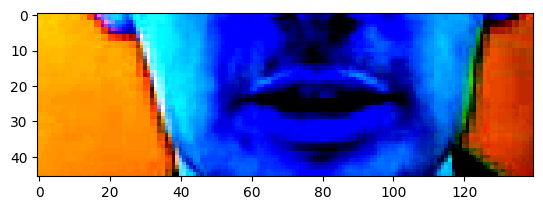

In [8]:
plt.imshow(frames[41].permute(1,2,0))

In [9]:
print(''.join(num_to_char(label.tolist(), idx2word)))

bin white at m nine soon


In [10]:
def split_dataset(dataset, val_split=0.1):
    n_val = int(len(dataset) * val_split)
    n_train = len(dataset) - n_val
    return torch.utils.data.random_split(dataset, [n_train, n_val])

train_dataset, val_dataset = split_dataset(dataset)
print(len(train_dataset), len(val_dataset))

900 99


In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=4)

In [12]:
class LipNet(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size=128, dropout=0.4, input_channels=1):
        super().__init__()
                
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels=input_channels, out_channels=128, kernel_size=(3,3,3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            # nn.Dropout3d(dropout),
            
            nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(3,3,3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.BatchNorm3d(256),
            nn.ReLU(True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            # nn.Dropout3d(dropout),
            
            nn.Conv3d(in_channels=256, out_channels=75, kernel_size=(3,3,3), stride=(1, 1, 1), padding=(1, 1, 1)),
            nn.BatchNorm3d(75),
            nn.ReLU(True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            # nn.Dropout3d(dropout)
        )
        
        
        self.lstm1 = nn.LSTM(input_size=75 * (46 // 8) * (140 // 8), hidden_size=hidden_size,
                             num_layers=1, batch_first=False, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)
        
        self.lstm2 = nn.LSTM(input_size=hidden_size*2, hidden_size=hidden_size,
                             num_layers=1, batch_first=False, bidirectional=True)
        self.dropout2 = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, vocab_size+1)
        
        self.initialize_weights()
        
    def forward(self, x):
        x = self.conv(x)
        # print(x.shape)
        x = x.permute(2, 0, 1, 3, 4).contiguous()
        # (B, C, T, H, W)->(T, B, C*H*W)
        # print(x.shape)
        x = x.view(x.size(0), x.size(1), -1)
        # print(x.shape)
        
        self.lstm1.flatten_parameters()
        self.lstm2.flatten_parameters()
        
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        x = self.fc(x)
        x = x.permute(1, 0, 2).contiguous()
        return x
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
                
        print('Model weights initialized.')

In [13]:
 # deterministic training
seed = 71
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
model = LipNet(vocab_size=len(word2idx), input_size=75, input_channels=3, hidden_size=128).to(device)
# model

Model weights initialized.


In [14]:
# torch.cuda.empty_cache()
# output = model(frames.permute(0,2,1,3,4))

In [15]:
def ctc_greedy_decode(y_pred, idx2word, blank_index=0):
    # Apply softmax to the model outputs to get probabilities
    probs = F.softmax(y_pred, dim=-1)
    
    # Get the predicted classes by taking the argmax
    predicted_indices = torch.argmax(probs, dim=-1)  # Shape: (batch_size, max_time)

    # Now we will decode the indices into strings
    decoded_outputs = []
    for batch_idx in range(predicted_indices.size(0)):
        current_output = []
        previous_index = -1  # Initialize to -1 to not include blank at the start
        
        for time_step in range(predicted_indices.size(1)):
            index = predicted_indices[batch_idx, time_step].item()
            if index != blank_index and index != previous_index:
                current_output.append(index)
            previous_index = index
        
        decoded_outputs.append(current_output)  # Store decoded output for each batch
    print(decoded_outputs)
    return decoded_outputs

In [16]:
lr = 1e-5
criterion = nn.CTCLoss(zero_infinity=True, blank = 0)
optimizer = optim.Adam(model.parameters(), lr=lr)

lambda_lr = lambda epoch: 1.0 if epoch < 30 else math.exp(-0.1 * (epoch - 29))
# Use LambdaLR with your custom schedule
lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)

In [17]:

def ctc_loss_fn(y_true, y_pred, ctc_loss):
    batch_len = y_true.size(0)  # Number of sequences in the batch
    input_length = y_pred.size(1)  # Time steps per batch sequence

    input_lengths = torch.full((y_pred.size(0),), y_pred.size(1), dtype=torch.long).to(device)
    target_lengths = torch.full((y_true.size(0),), y_true.size(1), dtype=torch.long).to(device)

    # print(input_lengths, target_lengths, y_true.size(), y_pred.shape)
    
    y_preds_logits = y_pred.permute(1,0,2).log_softmax(dim=2)

    loss = ctc_loss(y_preds_logits, y_true, input_lengths, target_lengths)
    
    return loss



def save_checkpoint(model, optimizer, epoch, loss, checkpoint_path, min_loss, is_best=False):
    
    if not os.path.exists(os.path.dirname(checkpoint_path)):
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss,
        'min_loss': min_loss,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved at {checkpoint_path}')
    
    if is_best:
        best_path = checkpoint_path.replace('.pt', '_best.pt')
        torch.save(checkpoint, best_path)
        print(f'Best model saved at {best_path}')

In [18]:
def train(model, dataloader, criterion, optimizer, device, lr_scheduler,print_every=40):
    model.train()
    
    total_loss = 0.0
    
    for i, (frames, labels) in enumerate(dataloader):
        frames, labels = frames.to(device), labels.to(device)
        
        optimizer.zero_grad()

        frames = frames.permute(0,2,1,3,4)
        output = model(frames)
        

        loss = ctc_loss_fn(labels, output, criterion)
         
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        frames, labels = frames.cpu(), labels.cpu()
        
        if (i+1) % print_every == 0:
            ctc_greedy_decode(output.clone(), idx2word)
            print(f'Batch {i+1}/{len(dataloader)} - Loss: {loss.item()}')
    
    # lr_scheduler.step()
    print(f'Learning rate: {lr_scheduler.get_last_lr()}')
            
    return total_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device, print_every=10):
    model.eval()
    
    total_loss = 0.0
    
    with torch.inference_mode():
        for i, (frames, labels) in enumerate(dataloader):
            frames, labels = frames.to(device), labels.to(device)
            
            output = model(frames.permute(0,2,1,3,4))
             
            loss = ctc_loss_fn(labels, output, criterion)
            
            total_loss += loss.item()
            
            frames, labels = frames.cpu(), labels.cpu()
            
            if (i+1) % print_every == 0:
                ctc_greedy_decode(output.clone(), idx2word)
                print(f'Batch {i+1}/{len(dataloader)} - Loss: {loss.item()}')
                
            
    return total_loss / len(dataloader)

In [19]:
from tqdm.auto import tqdm
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, lr_scheduler, num_epochs, device, checkpoint_path='/kaggle/working/check.pt', prev_checkpoint=None, new_lr = None ,  print_every=10):

     
    min_val_loss = float('inf')
    start_epoch = 0

    if prev_checkpoint is not None:
        checkpoint = torch.load(prev_checkpoint)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        min_val_loss = checkpoint['min_loss']
        print(f'Model loaded from checkpoint {prev_checkpoint}', start_epoch, "Old Loss", min_val_loss)
        for param_group in optimizer.param_groups:
            print("Old lr: ", param_group['lr'])
            if new_lr:
                param_group['lr'] = new_lr
                print("New lr: ", param_group['lr'])
   
        
    
    loss_history = {'train': [], 'val': []}    
    for epoch in tqdm(range(start_epoch, start_epoch+num_epochs)):
        print(f'Epoch {epoch}/{start_epoch+num_epochs}')
        
        train_loss = train(model, train_dataloader, criterion, optimizer, device, lr_scheduler,print_every )
        loss_history['train'].append(train_loss)
        
        val_loss = evaluate(model, val_dataloader, criterion, device, print_every)
        loss_history['val'].append(val_loss)
        
        print(f'Train Loss: {train_loss} - Val Loss: {val_loss}')
        
        min_val_loss = min(min_val_loss, val_loss)
        
        save_checkpoint(model, optimizer, epoch, val_loss, checkpoint_path, min_val_loss,is_best=(val_loss == min_val_loss))
        
    return loss_history

num_epochs = 50
prev_checkpoint= '/kaggle/input/lipnet/pytorch/default/4/check_best2.pt'
loss_history = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, lr_scheduler , num_epochs, device, prev_checkpoint = prev_checkpoint, new_lr = lr)

/tmp/ipykernel_23/2537021824.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(prev_checkpoint)


Model loaded from checkpoint /kaggle/input/lipnet/pytorch/default/4/check_best2.pt 143 Old Loss 0.46285814642906187
Old lr:  2e-05
New lr:  1e-05


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 143/193
[[16, 12, 1, 25, 39, 2, 12, 5, 39, 1, 20, 39, 5, 9, 5, 39, 1, 7, 9, 14], [16, 12, 1, 3, 39, 18, 5, 4, 39, 23, 9, 20, 8, 39, 6, 9, 22, 5, 39, 19, 15, 15, 14], [19, 5, 20, 39, 7, 18, 5, 39, 9, 39, 6, 15, 39, 16, 12, 5, 1, 19], [12, 1, 25, 39, 18, 5, 5, 4, 39, 2, 39, 22, 5, 39, 1, 9, 14], [19, 5, 1, 39, 23, 8, 9, 5, 39, 9, 20, 8, 39, 15, 23, 14, 15, 23, 15, 23], [16, 12, 1, 3, 39, 5, 12, 18, 5, 39, 9, 14, 39, 15, 18, 39, 16, 12, 1, 5, 19, 5], [12, 1, 25, 39, 7, 18, 5, 39, 23, 9, 20, 8, 39, 20, 39, 15, 20, 39, 16, 5, 12, 5, 1, 19, 5], [12, 1, 3, 39, 2, 12, 9, 20, 5, 39, 2, 25, 20, 39, 5, 22, 5, 39, 19, 15, 14], [16, 12, 1, 3, 5, 39, 7, 18, 5, 39, 9, 25, 39, 22, 5, 39, 19, 15, 15], [16, 12, 1, 3, 5, 39, 7, 18, 5, 4, 39, 9, 20, 39, 14, 5, 39, 15, 15, 14]]
Batch 10/90 - Loss: 0.36590176820755005
[[19, 5, 20, 39, 18, 14, 39, 2, 39, 14, 5, 22, 5, 39, 19, 15, 15, 14], [2, 9, 20, 39, 18, 5, 14, 39, 9, 14, 39, 5, 18, 20, 5, 39, 15, 23], [19, 5, 20, 39, 18, 5, 39, 9, 20, 39, 9, 22, 5,

In [20]:
model.eval()
frames, labels  = next(iter(train_dataloader))

In [21]:
labels.shape

torch.Size([10, 29])

In [22]:
output = model(frames.permute(0,2,1,3,4).to(device))

In [23]:
# output = output.permute(1, 0, 2)
print('Output shape:', output.shape)
ctcts = ctc_greedy_decode(output, idx2word)


Output shape: torch.Size([10, 75, 41])
[[19, 5, 20, 39, 2, 12, 21, 5, 39, 1, 20, 39, 6, 22, 5, 39, 19, 15, 14], [2, 9, 14, 39, 7, 18, 5, 14, 39, 9, 14, 39, 6, 9, 22, 5, 39, 19, 15, 14], [16, 12, 1, 3, 5, 39, 2, 12, 21, 5, 39, 2, 25, 39, 18, 39, 14, 15, 23], [12, 1, 25, 39, 18, 5, 4, 39, 9, 20, 39, 15, 5, 39, 19, 15, 14], [16, 12, 1, 3, 5, 39, 2, 12, 21, 5, 39, 23, 9, 20, 8, 39, 8, 18, 5, 39, 1, 7, 1, 9, 14], [16, 12, 1, 3, 5, 39, 23, 8, 9, 20, 5, 39, 25, 39, 9, 20, 39, 16, 12, 5, 1, 19, 5], [2, 9, 14, 39, 2, 12, 21, 5, 39, 9, 20, 8, 39, 26, 18, 15, 39, 16, 12, 5, 1, 19, 5], [16, 12, 1, 3, 5, 39, 18, 5, 4, 39, 9, 14, 39, 14, 9, 5, 39, 1, 7, 1, 9, 14], [2, 9, 14, 39, 23, 8, 9, 20, 5, 39, 23, 20, 8, 39, 14, 5, 39, 19, 15, 14], [12, 1, 25, 39, 18, 5, 4, 39, 1, 20, 39, 15, 14, 15, 23]]


In [24]:
for (out, label)  in zip(ctcts, labels):
    print("".join(num_to_char(label.tolist(), idx2word)))
    print("".join(num_to_char(out, idx2word)))
    print()

set blue at a five soon
set blue at fve son

bin green in t five soon
bin gren in five son

place blue by c four now
place blue by r now

lay red with f one soon
lay red it oe son

place blue with x three again
place blue with hre again

place white by d eight please
place white y it please

bin blue with t zero please
bin blue ith zro please

place red in i nine again
place red in nie again

bin white with u one soon
bin white wth ne son

lay red at e two now
lay red at onow



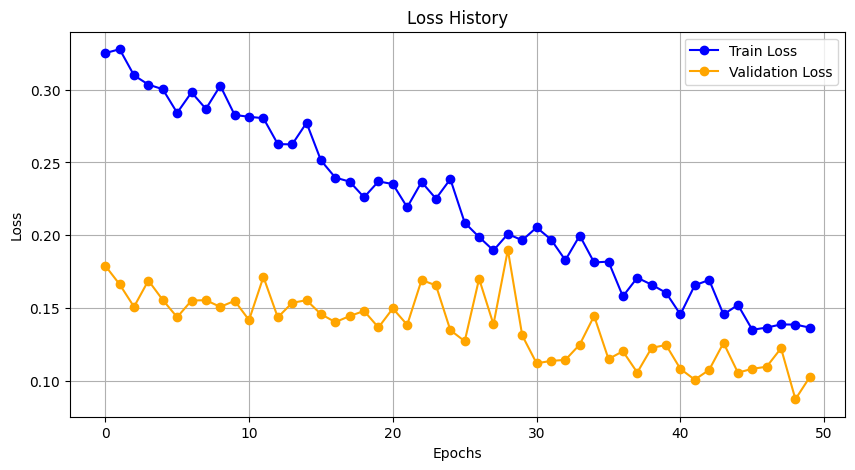

In [25]:
import matplotlib.pyplot as plt

def plot_loss(history, title='Loss History', xlabel='Epochs', ylabel='Loss'):
    plt.figure(figsize=(10, 5))
    
    # Plot training loss
    plt.plot(history['train'], label='Train Loss', color='blue', marker='o')
    
    # Plot validation loss
    plt.plot(history['val'], label='Validation Loss', color='orange', marker='o')
    
    # Adding labels and title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    
    # Show the plot
    plt.show()

plot_loss(loss_history)